<h1 style="font-size:300%">Car Price prediction using linear regression</h1>
BSHT Michielsen MSc

Updated by Jacco Snoeren July 2023

This notebook shows an example of applying linear regression to predict the price of a second hand car. Linear regression uses the assumption that features correlate with a target in a linear way, i.e. you can draw a straight line through their plot. In nature, most things however are not really linear and therefore linear regression is often not the best choice if high quality results are required. Nevertheless linear regression has a rather short training time and can produce fairly accurate predictions very quickly.

The case below has the goal of predicting the price of a second hand car, based on the characteristics of that car. The dataset ['auto_price' from OpenML](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=lte_1&id=195) is used, which originally was a data set for car insurances predictions. As a result, some features, like risk factors and such, are not useful for this case and are removed early on.

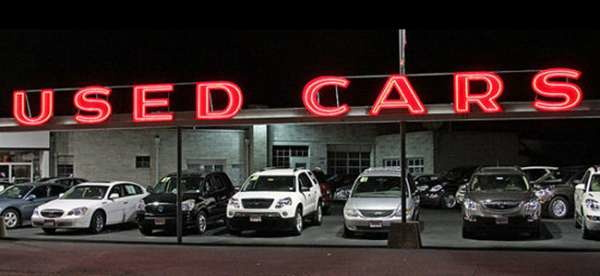

In [2]:
import io, math
from scipy.io import arff
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error

import sklearn
import pandas
import seaborn
import shap

print("scikit-learn version:", sklearn.__version__)     # 1.3.0
print("pandas version:", pandas.__version__)            # 2.1.4
print("seaborn version:", seaborn.__version__)          # 0.12.1
print("shap version:", shap.__version__)                # 0.42.1

scikit-learn version: 1.3.0
pandas version: 2.1.4
seaborn version: 0.12.2
shap version: 0.42.1


# 📦 Data provisioning

Perhaps in a full case the data provisioning would comprise of more steps, however, here for demo purposes we limit it to just loading the data and removing the features that are related to the insurance. Note that the function `loadarff` cannot load data files from URLs, so the data file needs to be [downloaded](https://www.openml.org/search?type=data&sort=runs&status=active&qualities.NumberOfClasses=lte_1&id=195) prior to being loaded.

In [3]:
data, meta = arff.loadarff("dataset_2181_auto_price.arff")
meta

Dataset: auto_price
	symboling's type is nominal, range is ('-3', '-2', '-1', '0', '1', '2', '3')
	normalized-losses's type is numeric
	wheel-base's type is numeric
	length's type is numeric
	width's type is numeric
	height's type is numeric
	curb-weight's type is numeric
	engine-size's type is numeric
	bore's type is numeric
	stroke's type is numeric
	compression-ratio's type is numeric
	horsepower's type is numeric
	peak-rpm's type is numeric
	city-mpg's type is numeric
	highway-mpg's type is numeric
	price's type is numeric

According to the OpenML data definition the features named `symboling` and `normalized-losses` are related to car insurances, and therefore are not characteristics of the car itself and are to be removed here. After that, the function `describe` gives a statistical overview of the data.

In [4]:
df = pandas.DataFrame(data)
df.drop(labels=["symboling", "normalized-losses"], axis=1, inplace=True)
df.describe()

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,98.264151,172.413836,65.607547,53.899371,2461.138365,119.226415,3.300126,3.236352,10.161132,95.836478,5113.836478,26.522013,32.081761,11445.729560
std,5.167416,11.523177,1.947883,2.268761,481.941321,30.460791,0.267336,0.294888,3.889475,30.718583,465.754864,6.097142,6.459189,5877.856195
min,86.600000,141.100000,60.300000,49.400000,1488.000000,61.000000,2.540000,2.070000,7.000000,48.000000,4150.000000,15.000000,18.000000,5118.000000
25%,94.500000,165.650000,64.000000,52.250000,2065.500000,97.000000,3.050000,3.105000,8.700000,69.000000,4800.000000,23.000000,28.000000,7372.000000
50%,96.900000,172.400000,65.400000,54.100000,2340.000000,110.000000,3.270000,3.270000,9.000000,88.000000,5200.000000,26.000000,32.000000,9233.000000
75%,100.800000,177.800000,66.500000,55.500000,2809.500000,135.000000,3.560000,3.410000,9.400000,114.000000,5500.000000,31.000000,37.000000,14719.500000
max,115.600000,202.600000,71.700000,59.800000,4066.000000,258.000000,3.940000,4.170000,23.000000,200.000000,6600.000000,49.000000,54.000000,35056.000000


# 📃 Sample the data

Here a random sample of 5 cars is taken from the data set to see what kind of values we have for the features and what sort of prices these values imply. 

In [5]:
df.sample(5)

,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
49,93.7,157.3,64.4,50.8,1918.0,92.0,2.97,3.23,9.4,68.0,5500.0,37.0,41.0,5389.0
38,98.8,177.8,66.5,53.7,2385.0,122.0,3.39,3.39,8.6,84.0,4800.0,26.0,32.0,8845.0
84,93.7,157.3,63.8,50.8,1918.0,90.0,2.97,3.23,9.4,68.0,5500.0,37.0,41.0,5572.0
152,104.3,188.8,67.2,56.2,3045.0,130.0,3.62,3.15,7.5,162.0,5100.0,17.0,22.0,18420.0
148,104.3,188.8,67.2,56.2,2912.0,141.0,3.78,3.15,9.5,114.0,5400.0,23.0,28.0,12940.0


A histogram shows the distribution of the cars against the target variable price.

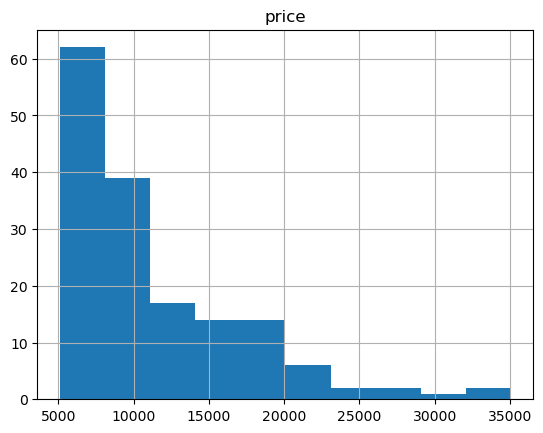

In [6]:
plot = df.hist(column="price")

# 🛠️ Preprocessing

The step of preprocessing contains several activities to consider before we can start training the algorithm and produce a model that can predict our target variable namely the price a second hand car.

## 💡 Feature selection

The heatmap below will be used to select a suitable set of features (characteristics of the car) to predict the price upon. A heatmap is a representation of the correlations between the features in the data set. It is common to put the target variable at the end, so the labels next to heatmap are easiest to read for the target variable.

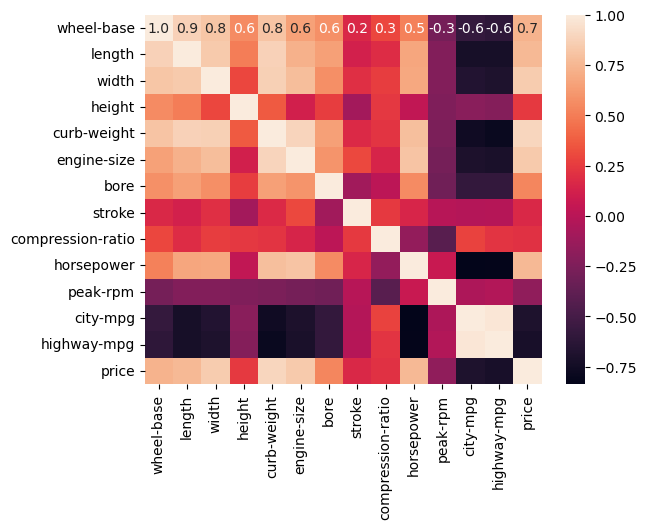

In [7]:
correlations = df.corr()
plot = seaborn.heatmap(correlations, cbar=True, annot=True, fmt=".1f")

The approach taken here is to select any feature with a correlation coefficient of .7 or higher, so any `0.7` or higher or `-0.7` or lower from the heatmap. The assumption is that picking only the features with high correlations will give a good prediction outcome by including as much as possible of the information from the independent variables, while at the same time excluding noise.

In [8]:
features = ["wheel-base", "length", "width", "curb-weight", "engine-size", "horsepower", "city-mpg", "highway-mpg"]
target = "price"

X = df[features]
y = df[target]

## 🪓 Splitting into train/test

Before the model can be trained, a little part of the data is to be put aside for testing purposes. The reasoning here is that the model trains with, for example 80% of the data available, and the other 20% is used to ask it to predict the target variable for. Because the true target variable of that 20% is known, we can compare the predictions with the ground truth and devise how well the model performs.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 159 observations, of which 127 are now in the train set, and 32 in the test set.


## ⚖️ Scaling

For other machine learning algorithms scaling may be needed, however, linear regression can usually do fine without scaling because it will make a mathematically formula to predict the target with, that can adapt to features in different units. However, for visualization purposes it may be required to scale anyway, or plots may look bad. For now, no scaling is applied. 

# 🧬 Modelling

In this step only the train set is used to fit the model, which in this case uses a Linear Regression algorithm named [LinearRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). And after that the test set is used to calculate the model's score, in other words how well it performs. For regression problems the score is provided as the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) denoted *R²*, which is a fraction where any value closer to 1 is considered better, and 1 itself (100% accurate) is usually impossible.


In [10]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
result = model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("R²:", score)

R²: 0.7926375015336046


# 🔬 Evaluation

Now, for each of the 32 cars in the test set the model makes a prediction of the price. Since the true price is known, it is then possible to compare the truth with the prediction and calculate an error from that, meaning *"how far away is the prediction from the truth?"*. Note that the error is absolute (non-negative), and in this example it is also cast to an integer for legibility reasons.

In [11]:
predictions = model.predict(X_test)

prediction_overview = pandas.DataFrame()
prediction_overview["truth"] = y_test
prediction_overview["prediction"] = predictions
prediction_overview["error"] = prediction_overview["truth"] - prediction_overview["prediction"]
prediction_overview["error"] = abs(prediction_overview["error"].astype(int))
prediction_overview = prediction_overview.reset_index(drop=True)
prediction_overview

,truth,prediction,error
0,10295.0,7277.000572,3017
1,11245.0,11191.502819,53
2,6229.0,6120.009128,108
3,11850.0,12038.597273,188
4,16630.0,16897.708563,267
5,6479.0,5617.703119,861
6,25552.0,24199.550534,1352
7,5572.0,6247.011768,675
8,10595.0,10977.226289,382
9,5118.0,6869.579370,1751


Moreover, it is possible to use a plot to visualise the relation between the true price and the predicted price. The reasoning here is that the closer the dots are to the line, the more accurate the model can predict the price of a second hand car. The shaded zone is the 95% certainty zone, any dot within that zone would have a 95% accurate prediction, and thus a low error.

<Axes: xlabel='predicted price', ylabel='true price'>

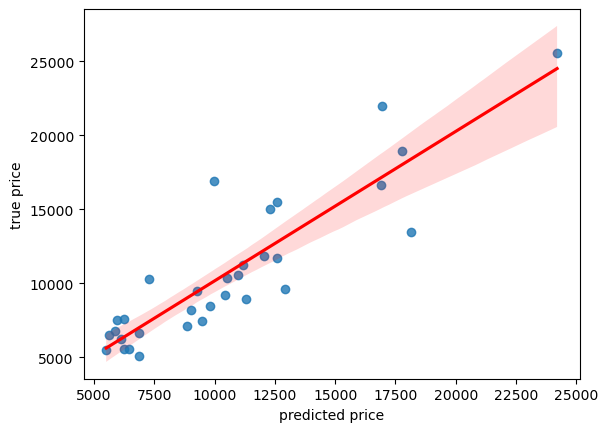

In [12]:
plot = seaborn.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted price")
plot.set_ylabel("true price")
plot

It appears that the model does fairly well for the lower priced cars, of which most dots are in or near the shaded zone, then for the medium priced cars it does a little less good, and for the higher priced cars it does sort of fair again. As linear regression is limited to drawing straight lines, it has to do some sort of average over the whole population. Now, if the relationship between the selected features and the target variable is not really linear (not a straight line), but more of a curve, linear regression will exhibit this kind of behaviour where it seems to predict well at the extremes but a little less in the middle, there where the relationship curves away from the average.

To get a meaningful indication of the errors that the model makes, it possible to calculate the [maximum error](https://scikit-learn.org/stable/modules/model_evaluation.html#max-error) and the root of the [mean squared error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error), which are both useful indicators of error because they are **in the same unit as the target variable**, here American dollars. Note that both are rounded up to the nearest integer using `math.ceil()` for legibility reasons.

In [13]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 6936
Root Mean Squared Error: 2257


This model will predict prices for second hand cars which on average are 2257 American dollars off from the truth, but may occasionally produce an error as high as 6936 American dollars. Maybe this model may be not so good yet, which could be due to the fact that the selected features do in fact correlate with the target, but not in a linear way, as shown by the plot.

# 🛠️ Preprocessing

As always there is again several different ways to address the issue of 'correlated but not linearly' features with the target variable. Quite possibly, if high quality results are expected, an algorithm other than linear regression should be used, one that can in fact draw curved lines instead. But because this notebook is on linear regression, here a different approach is attempted. 

## 💡 Feature selection

Instead of picking all features that have a good correlation with the target variable, now those features that have a good correlation as well as having a correlation that seems linear with the target variable are being picked. To know whether features correlate with the target in a linear way, a pairplot can give insights. If the dots in the pairplot seem to draw a straight line (rather than curved), then linear regression will happily use that feature. If the dots are not nicely in a line, then that feature may produce noise that disturbs the linear regression. To help us, we draw a regression line in the plot as well.

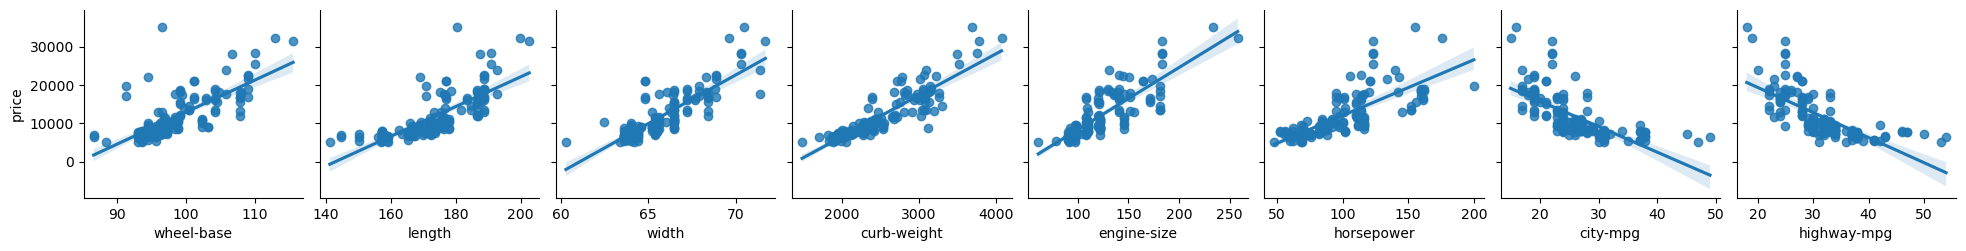

In [14]:
plot = seaborn.pairplot(df, x_vars=features, y_vars=target, kind="reg")

Looking at the pairplots it seems that the features `length`, `width` and `curb-weight` exhibit, aside from some outliers, a reasonably straight line. The feature `engine-size` is rather straight too, but has a large number of outliers relative to the inliers. The features `wheel-base` and `horsepower` have a fair number of inliers and are reasonably linear as well, but have rather extreme outliers that may produce noise. The features `city-mpg` and `highway-mpg` exhibit typical curved line behaviour and are certainly not a good idea to pick here. In conclusion, the features `length`, `width` and `curb-weight` are selected. Obviously the target variable remains `price` and therefore `y` does not change.

In [15]:
features = ["length", "width", "curb-weight"]
X = df[features]

## 🪓 Splitting into train/test

The same split strategy is used as in the previous section.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
print("There are in total", len(X), "observations, of which", len(X_train), "are now in the train set, and", len(X_test), "in the test set.")

There are in total 159 observations, of which 127 are now in the train set, and 32 in the test set.


# 🧬 Modelling

Nothing is changed in the modelling section either, so this second model can be compared to the first model.

In [17]:
model = LinearRegression()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("R²:", score)

R²: 0.8223328477695311


# 🔬 Evaluation

Like in the previous step, the same evaluation metrics are used as to see whether the second model is an improvement over the first model.

In [18]:
predictions = model.predict(X_test)

<Axes: xlabel='predicted price', ylabel='true price'>

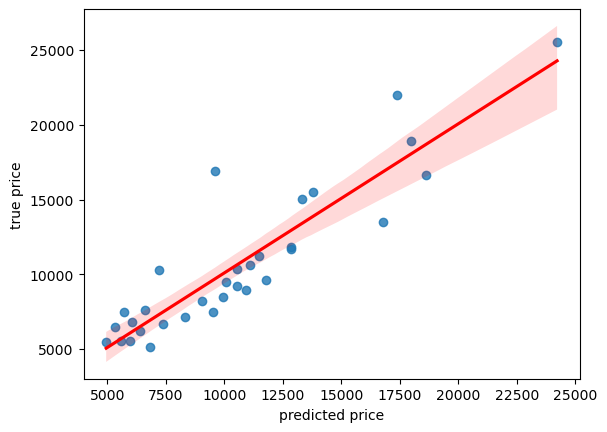

In [19]:
plot = seaborn.regplot(y=y_test.values.flatten(), x=predictions.flatten(), line_kws={"color": "r"})
plot.set_xlabel("predicted price")
plot.set_ylabel("true price")
plot

In [20]:
me = max_error(y_test, predictions)
me = math.ceil(me)
print("Max Error:", me)

mse = mean_squared_error(y_test, predictions)
rmse = math.sqrt(mse)
rmse = math.ceil(rmse)
print("Root Mean Squared Error:", rmse)

Max Error: 7327
Root Mean Squared Error: 2089


What do you conclude based on these error values? What information does the max error and root mean squared error give you?

# 🗳️ Conclusion
Most likely the second model is better, because it has a mean error that is a about 18% smaller than the mean error of the first model. However, probably due to the fact that the second model has less features to train on and therefore has less information about the case, it may occasionally produce a maximum error that is larger than the maximum error that the first model. Thus, there is no absolute clear winner here, but in general the second model will likely give better predictions for second hand car prices due to the fact that its R² is higher than the first model.